## Migration network completion
There are evidences that migration and trade networks are linked [1]. As we are missing many of the migration links, in this notebook we explore the possibility of completing the migration network using trande network info

[1] Sgrignoli, P., Metulini, R., Schiavo, S., Riccaboni, M., 2015. The relation between global migration and trade networks. Physica A: Statistical Mechanics and its Applications 417, 245–260. https://doi.org/10.1016/j.physa.2014.09.037



In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed/'
    input_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/raw/'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from urllib.parse import urlparse
from functools import reduce

from src.utils.utils_s3 import read_s3_graphml
from src.data.migration_network import EstimatedMigrationNetwork

In [4]:
year='2015'

In [5]:
B = read_s3_graphml(os.path.join(output_filepath, year, 'B_country.graphml'))
A = read_s3_graphml(os.path.join(output_filepath, year, 'A_country.graphml'))
M = read_s3_graphml(os.path.join(output_filepath, year, 'migration_network.graphml'))

In [6]:
df_list = []

for network in A, B, M:
    link_list = [(c1, c2, w['weight']) for c1, c2, w in network.edges(data=True)]
    df_ = pd.DataFrame(link_list, columns = ['country_from', 'country_to', 'weight'])
    df_.set_index(['country_from', 'country_to'], inplace=True)
    
    df_list.append(df_)

In [7]:
df = reduce(lambda df1,df2: pd.merge(df1,df2,on=['country_from', 'country_to'], how='outer'), df_list)
df.columns = ['a_link', 'b_link', 'm_link']

In [8]:
df.describe()

,a_link,b_link,m_link
count,3.609900e+04,3.609900e+04,4.996000e+03
mean,2.662586e-03,2.585357e-03,2.490384e-04
std,2.951920e-02,2.941462e-02,1.834524e-03
min,3.494289e-11,2.453964e-10,0.000000e+00
25%,5.660713e-06,6.929959e-06,8.747368e-07
50%,2.848555e-05,2.781350e-05,8.948309e-06
75%,1.654927e-04,1.200384e-04,5.760262e-05
max,6.129783e-01,8.945897e-01,5.859059e-02


## Simple regression model

In [9]:
df_model = df[df.b_link>1.e-6]
df_model = df_model.dropna()

In [10]:
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
    
y = df_model['m_link']
X = df_model[['a_link', 'b_link']]
X = sm.add_constant(X)

model = sm.OLS(y,X)
model = QuantReg(y,X)

results = model.fit(q=.99)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                 m_link   Pseudo R-squared:               0.3536
Model:                       QuantReg   Bandwidth:                   0.0004289
Method:                 Least Squares   Sparsity:                      0.01737
Date:                Wed, 04 Aug 2021   No. Observations:                 4980
Time:                        09:01:04   Df Residuals:                     4977
                                        Df Model:                            2
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   2.47e-05     14.751      0.000       0.000       0.000
a_link         0.9076      0.003    337.823      0.000       0.902       0.913
b_link         0.4610      0.003    166.596      0.000       0.456       0.466
==============================================================================
"""

## Dummy model
DIOC-E (release 3.0) (year 2000) data found in https://www.un.org/en/development/desa/population/migration/data/estimates2/estimates19.asp

In [11]:
B = read_s3_graphml(os.path.join(output_filepath, '2015', 'B_country.graphml'))

e = EstimatedMigrationNetwork(B, input_filepath, output_filepath)
estimated_M = e.estimate_emigration_rate()

In [13]:
df_list = []

for network in A, B, M, estimated_M:
    link_list = [(c1, c2, w['weight']) for c1, c2, w in network.edges(data=True)]
    df_ = pd.DataFrame(link_list, columns = ['country_from', 'country_to', 'weight'])
    df_.set_index(['country_from', 'country_to'], inplace=True)
    
    df_list.append(df_)
    
df = reduce(lambda df1,df2: pd.merge(df1,df2,on=['country_from', 'country_to'], how='outer'), df_list)
df.columns = ['a_link', 'b_link', 'm_link', 'm_estimated_link']

In [14]:
df.dropna().sort_values(by='m_link')

a_link    b_link    m_link  m_estimated_link
country_from country_to                                                
STP          EST         0.001310  0.000551  0.000000      1.436032e-04
MDV          LVA         0.000196  0.000152  0.000000      2.478341e-06
             LUX         0.000133  0.000055  0.000000      8.995850e-07
CHL          CHL         0.373862  0.365353  0.000000      0.000000e+00
MDV          HUN         0.000162  0.000140  0.000000      2.274926e-06
...                           ...       ...       ...               ...
ROU          DEU         0.017973  0.020075  0.024291      2.472608e-03
BGR          DEU         0.015497  0.017942  0.025879      2.577978e-03
WSM          NZL         0.013978  0.001985  0.031667      1.622563e-03
ALB          DEU         0.005038  0.002660  0.053787      1.444638e-03
SYR          DEU         0.007129  0.021630  0.058591      7.604587e-04

[4249 rows x 4 columns]

In [15]:
df.dropna().describe(include='all')

,a_link,b_link,m_link,m_estimated_link
count,4.249000e+03,4.249000e+03,4.249000e+03,4249.000000
mean,2.667199e-03,2.498743e-03,2.029331e-04,0.000239
std,1.717074e-02,1.681145e-02,1.629217e-03,0.001376
min,7.177867e-07,1.949971e-07,0.000000e+00,0.000000
25%,9.491331e-05,4.569054e-05,6.495946e-07,0.000003
50%,3.610110e-04,1.905226e-04,7.189137e-06,0.000017
75%,1.449650e-03,1.003103e-03,4.690202e-05,0.000101
max,4.265551e-01,4.188109e-01,5.859059e-02,0.064429


In [21]:
df[(df.b_link == 0)].sort_values(by='m_estimated_link').dropna()

,,a_link,b_link,m_link,m_estimated_link
country_from,country_to,,,,
DNK,DNK,0.391458,0.382248,0.0,0.000000
NOR,NOR,0.318208,0.305736,0.0,0.000000
CHL,CHL,0.373862,0.365353,0.0,0.000000
HUN,HUN,0.314207,0.299422,0.0,0.000000
JPN,JPN,0.423077,0.418811,0.0,0.000000
...,...,...,...,...,...
BMU,NOR,0.000367,0.003003,0.0,0.001991
ATG,KOR,0.000835,0.003441,0.0,0.002115
SYC,NLD,0.000986,0.011703,0.0,0.003248


In [29]:
df.index[]

('ABW', 'ABW')

In [31]:
df[df.index.get_level_values(0) == 'ATG']

a_link    b_link  m_link  m_estimated_link
country_from country_to                                              
ATG          ATG         0.431913  0.391707     NaN          0.000000
             ABW         0.000058  0.000319     NaN          0.000196
             AFG         0.000050  0.000092     NaN          0.000056
             AGO         0.000126  0.000125     NaN          0.000077
             ALB         0.000101  0.000082     NaN          0.000050
...                           ...       ...     ...               ...
             WSM         0.000049  0.000061     NaN          0.000038
             YEM         0.000056  0.000132     NaN          0.000081
             ZAF         0.000242  0.000435     NaN          0.000267
             ZMB         0.000145  0.000095     NaN          0.000058
             ZWE         0.000121  0.000028     NaN          0.000017

[190 rows x 4 columns]

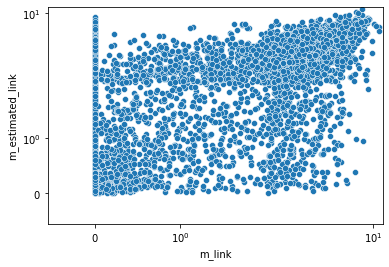

In [16]:
ax = sns.scatterplot(data=df.applymap(lambda x: np.log1p(x*1000000)), x = 'm_link', y = 'm_estimated_link')
ax.set_xscale('symlog')
ax.set_yscale('symlog')

<AxesSubplot:xlabel='0', ylabel='level_2'>

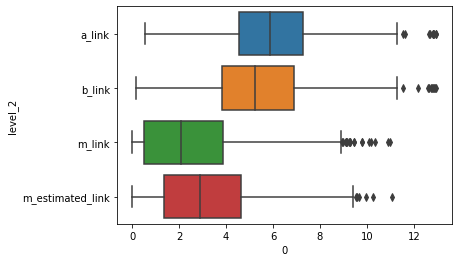

In [39]:
sns.boxplot(data = df.applymap(lambda x: np.log1p(x*1000000)).dropna().stack().reset_index(), x = 0, y = 'level_2')

In [17]:
df_model = df.applymap(lambda x: np.log1p(x*1000000)).dropna()

y = df_model['m_link']
X = df_model[['m_estimated_link']]
X = sm.add_constant(X)

model = sm.OLS(y,X)
#model = QuantReg(y,X)

results = model.fit(q=.99)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 m_link   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     2259.
Date:                Wed, 04 Aug 2021   Prob (F-statistic):               0.00
Time:                        09:01:06   Log-Likelihood:                -8330.4
No. Observations:                4249   AIC:                         1.666e+04
Df Residuals:                    4247   BIC:                         1.668e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5690      0.047     12.010      0.000       0.476       0.662
m_estimated_link     0.5976      0.013     47.525      0.000       0.573       0.622
==============================================================================
Omnibus:                      206.547   Durbin-Watson:                   1.360
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              296.514
Skew:                           0.448   Prob(JB):                     4.10e-65
Kurtosis:                       3.933   Cond. No.                         7.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""